# ICON Live Demo

To run this demo, please specify the directory where MNIST is stored. Note that if MNIST is not found on this path, it will be downloaded. Please also make sure the dependencies are installed. As only some common libraries (e.g., pytorch, sklearn, numpy, PIL, matplotlib) are used in this demo, we recommend you to try with a pytorch environment that is already installed on your machine.

In [1]:
root_dir = "xxx"

## Generate Source S and Target T

We randomly partitioned the 0s and 1s in MNIST to two splits, corresponding to the source domain S and target domain T respectively. For S, we reduce the brightness of 0s, and for T, we do so for 1s to create the scenario in Figure 2a.

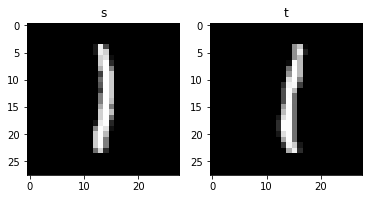

In [92]:
import argparse
import numpy as np
import torch
import torchvision
from torchvision import datasets
from torch import nn, optim, autograd
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision.models import resnet50
from PIL import Image
from sklearn.model_selection import train_test_split

class ColorMNIST(datasets.MNIST):
    def __init__(self, root, train=True, transform=None, download=False):
        super().__init__(root, train=train, transform=transform, target_transform=None, download=download)

    def __getitem__(self, index):
        img, target = self.data[index], int(self.targets[index])
        img = Image.fromarray(img.numpy().astype('uint8'), 'RGB')
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return img, target
    
def convert_to_rgb(images):
    images = images.repeat(1, 3, 1, 1)
    return images

def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

# normalize = transforms.Normalize((0.0,), (0.3081,))
train_transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
])
val_transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
])

mnist_s = ColorMNIST(root_dir, train=True, download=True, transform=train_transform)
mnist_t_unlab = ColorMNIST(root_dir, train=True, download=True, transform=train_transform)
mnist_t = ColorMNIST(root_dir, train=True, download=True, transform=val_transform)

dataset = ColorMNIST(root_dir, train=True, download=True, transform=train_transform)

mask_0 = dataset.targets == 0
mask_1 = dataset.targets == 1
selected = torch.logical_or(mask_0, mask_1)
data = dataset.data[selected].numpy()
targets = dataset.targets[selected].numpy()
data_s, data_t, y_s, y_t = train_test_split(data, targets, test_size=0.5)

mnist_s = ColorMNIST(root_dir, train=True, download=True, transform=train_transform)
mnist_t_unlab = ColorMNIST(root_dir, train=True, download=True, transform=train_transform)
mnist_t = ColorMNIST(root_dir, train=True, download=True, transform=val_transform)


def process_data(data, targets, source=True):
    # source: dark 0, bright 1
    # target: bright 0, dark 1
    mask_0 = targets == 0
    mask_1 = targets == 1
    data = torch.from_numpy(data)
    mean_val = 1.5
    std_val = 1.0
    if source:
        p_mask = mask_0
        p_data = data[mask_0,:,:]
    else:
        p_mask = mask_1
        p_data = data[mask_1,:,:]
    mean = torch.ones(p_mask.sum()) * mean_val
    std = torch.ones(p_mask.sum()) * std_val
    divider = torch.normal(mean, std).unsqueeze(1).unsqueeze(1).expand(-1,28,28)
    divider[divider <= 1.0] = 1.0
    
    p_data = (p_data.to(torch.float) / divider).to(torch.uint8)
    data[p_mask] = p_data
    return data


data_s = process_data(data_s, y_s)

data_t = process_data(data_t, y_t,  False)
data_s = convert_to_rgb(data_s.unsqueeze(1))
data_t = convert_to_rgb(data_t.unsqueeze(1))

mnist_s.data = data_s.clone()
mnist_t_unlab.data = data_t.clone()
mnist_t.data = data_t.clone()

mnist_s.targets = torch.from_numpy(y_s).clone()
mnist_t_unlab.targets = torch.from_numpy(y_t).clone()
mnist_t.targets = torch.from_numpy(y_t).clone()

to_pil = torchvision.transforms.ToPILImage()
plt.subplot(1,2,1)
plt.title("s")
plt.imshow(to_pil(mnist_s.data[100]))

plt.subplot(1,2,2)
plt.title("t")
plt.imshow(to_pil(mnist_t_unlab.data[101]))
plt.show()

## Define functions to help visualization

In [11]:
def save_features(train_s_loader, train_t_loader, feature_extractor):
    features_list = []
    targets_list = []
    if train_s_loader != None:
        for images, targets in train_s_loader:
            images = images.cuda()
            with torch.no_grad():
                features = (feature_extractor(images))
            features_list.append(features.detach().cpu())
            targets_list.append(targets.cpu())
            
    if train_t_loader != None:
        for images, targets in train_t_loader:
            images = images.cuda()
            with torch.no_grad():
                features = (feature_extractor(images))
            features_list.append(features.detach().cpu())
            targets_list.append(targets.cpu())
    features_list = torch.cat(features_list, dim=0)
    targets_list = torch.cat(targets_list, dim=0)
    features = features_list.numpy()
    targets = targets_list.numpy()
    return features, targets

def transform_features(features):
    from sklearn.decomposition import PCA
    from sklearn.manifold import TSNE
    pca = PCA(n_components=50)
    tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=1500)
    if features.shape[1] > 200:
        features_pca = pca.fit_transform(features)
    else:
        features_pca = features
    features_tsne = tsne.fit_transform(features_pca)
    return features_tsne
    
def plot_features(features_tsne, targets, num=500):
    import matplotlib.pyplot as plt
    from matplotlib.pyplot import figure
    from sklearn.naive_bayes import GaussianNB
    figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
    n_features = len(features_tsne) // 2
    features1 = features_tsne[:n_features]
    targets1 = targets[:n_features]
    features2 = features_tsne[n_features:]
    targets2 = targets[n_features:]
    plt.scatter(features1[targets1==0][:num,0], features1[targets1==0][:num,1], s=20, color=(0.89,0.102,0.102),marker='o')
    plt.scatter(features1[targets1==1][:num,0], features1[targets1==1][:num,1], s=30, color=(0.89,0.102,0.102),marker='^')

    plt.scatter(features2[targets2==0][:num,0], features2[targets2==0][:num,1], s=20, color=(0.122,0.47,0.706),marker='o')
    plt.scatter(features2[targets2==1][:num,0], features2[targets2==1][:num,1], s=30, color=(0.122,0.47,0.706),marker='^')
    plt.axis('off')

## Visualize Pre-trained Backbone Features (prior to training)

Legend: Red: Source domain; Blue: Target domain; Dot: "0"; Triangle: "1".

Overall, the pre-trained ResNet-50 backbone captures the digit shape and color features, and we see that the 0s and 1s are well-separated in both domains.

However, we also see a domain shift in the t-SNE feature, e.g., the clusters of "0"s in the source (red dot) and target domain (blue dot) are different.

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 12665 samples in 0.045s...
[t-SNE] Computed neighbors for 12665 samples in 3.657s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12665
[t-SNE] Computed conditional probabilities for sample 2000 / 12665
[t-SNE] Computed conditional probabilities for sample 3000 / 12665
[t-SNE] Computed conditional probabilities for sample 4000 / 12665
[t-SNE] Computed conditional probabilities for sample 5000 / 12665
[t-SNE] Computed conditional probabilities for sample 6000 / 12665
[t-SNE] Computed conditional probabilities for sample 7000 / 12665
[t-SNE] Computed conditional probabilities for sample 8000 / 12665
[t-SNE] Computed conditional probabilities for sample 9000 / 12665
[t-SNE] Computed conditional probabilities for sample 10000 / 12665
[t-SNE] Computed conditional probabilities for sample 11000 / 12665
[t-SNE] Computed conditional probabilities for sample 12000 / 12665
[t-SNE] Computed conditional probabilities for sam

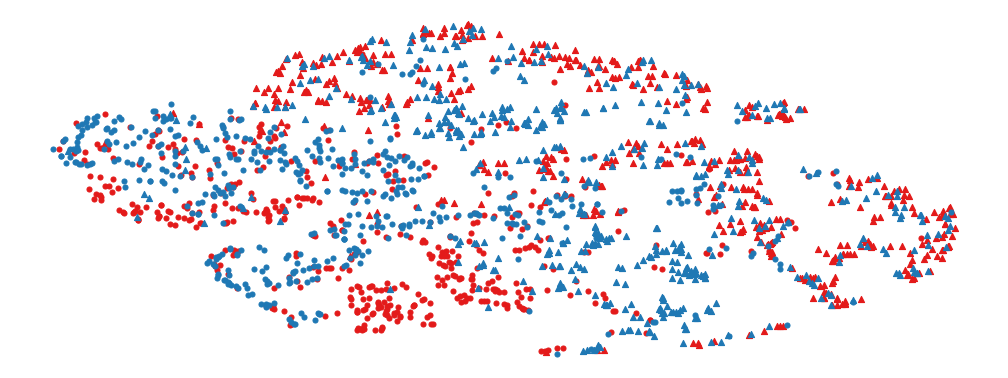

In [13]:
# Model
backbone = resnet50(pretrained=True).cuda()
backbone.fc = nn.Identity()

# Loaders
train_s_loader = torch.utils.data.DataLoader(mnist_s, batch_size=128, shuffle=True, drop_last=False, num_workers=24)
val_loader = torch.utils.data.DataLoader(mnist_t, batch_size=128, shuffle=False, drop_last=False, num_workers=24)

# Visualize
backbone.eval()
features, targets = save_features(train_s_loader, val_loader, backbone)
features = transform_features(features)
plot_features(features, targets, 500)

## S-Supervision

We train a baseline based on supervision in S. For simplicity, we use just cross-entropy loss without self-training/domain-alignment, as both of them are also grounded on the supervision in S (see paper). We use a very simple backbone: freezing the pre-trained ResNet-50 and appending a non-linear MLP, a linear classifier, and SGD as optimizer.

### Define Models and Loaders

In [14]:
# model
backbone = resnet50(pretrained=True).cuda()
backbone.fc = nn.Identity()
baseline_adaptor = nn.Sequential(nn.Linear(2048, 64), nn.ReLU(), nn.Linear(64, 16)).cuda()
baseline_fc = nn.Linear(16, 2).cuda()

# optimizer
optimizer = torch.optim.SGD(list(baseline_adaptor.parameters())+list(baseline_fc.parameters()), 0.01,momentum=0.9,weight_decay=1e-4)

# loaders
train_s_loader = torch.utils.data.DataLoader(mnist_s, batch_size=128, shuffle=True, drop_last=False, num_workers=24)
val_loader = torch.utils.data.DataLoader(mnist_t, batch_size=128, shuffle=False, drop_last=False, num_workers=24)

### Model Training

In [15]:
for epoch in range(5):
    loss_avg = 0
    acc_avg = 0.0
    backbone.eval()
    baseline_adaptor.train()
    for images, targets in train_s_loader:
        optimizer.zero_grad()
        images = images.cuda()
        targets = targets.cuda()
        with torch.no_grad():
            b_features = backbone(images)
        features = baseline_adaptor(b_features)
        outputs = baseline_fc(features)
        loss = nn.CrossEntropyLoss()(outputs, targets)
        loss.backward()

        acc1 = accuracy(outputs, targets, topk=(1,))[0]
        optimizer.step()   
        loss_avg += loss.item() / len(train_s_loader)
        acc_avg += acc1.item() / len(train_s_loader)
    print("Avg loss: %.4f" % loss_avg)
    print("Average acc:%.2f" % acc_avg)

    baseline_adaptor.eval()
    acc_avg = 0.0
    for images, targets in val_loader:
        images = images.cuda()
        targets = targets.cuda()
        with torch.no_grad():
            b_features = backbone(images)
            features = baseline_adaptor(b_features)
            outputs = baseline_fc(features)
        acc1 = accuracy(outputs, targets, topk=(1,))[0]
        acc_avg += acc1.item() / len(val_loader)
    print("Average val acc:%.2f" % acc_avg)

Avg loss: 0.5684
Average acc:69.73
Average val acc:56.92
Avg loss: 0.2393
Average acc:91.75
Average val acc:73.58
Avg loss: 0.1906
Average acc:93.49
Average val acc:74.30
Avg loss: 0.1711
Average acc:93.85
Average val acc:73.33
Avg loss: 0.1556
Average acc:94.43
Average val acc:75.03


### Visualize Features

By observing the samples in S, i.e., "0"s as red dots and "1"s as red triangle (don't look at blue ones yet), we see that they indeed lie on well-separated manifolds. However, by looking at the middle part of the plot, many 0s in T (blue dot) are mistakenly placed near 1s in S (red triangles), and similarly for 1s in T (blue triangles). This illustrates that the model captures the spurious correlation between digit color and label (as in Figure 2a red line).

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 12665 samples in 0.015s...
[t-SNE] Computed neighbors for 12665 samples in 0.368s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12665
[t-SNE] Computed conditional probabilities for sample 2000 / 12665
[t-SNE] Computed conditional probabilities for sample 3000 / 12665
[t-SNE] Computed conditional probabilities for sample 4000 / 12665
[t-SNE] Computed conditional probabilities for sample 5000 / 12665
[t-SNE] Computed conditional probabilities for sample 6000 / 12665
[t-SNE] Computed conditional probabilities for sample 7000 / 12665
[t-SNE] Computed conditional probabilities for sample 8000 / 12665
[t-SNE] Computed conditional probabilities for sample 9000 / 12665
[t-SNE] Computed conditional probabilities for sample 10000 / 12665
[t-SNE] Computed conditional probabilities for sample 11000 / 12665
[t-SNE] Computed conditional probabilities for sample 12000 / 12665
[t-SNE] Computed conditional probabilities for sam

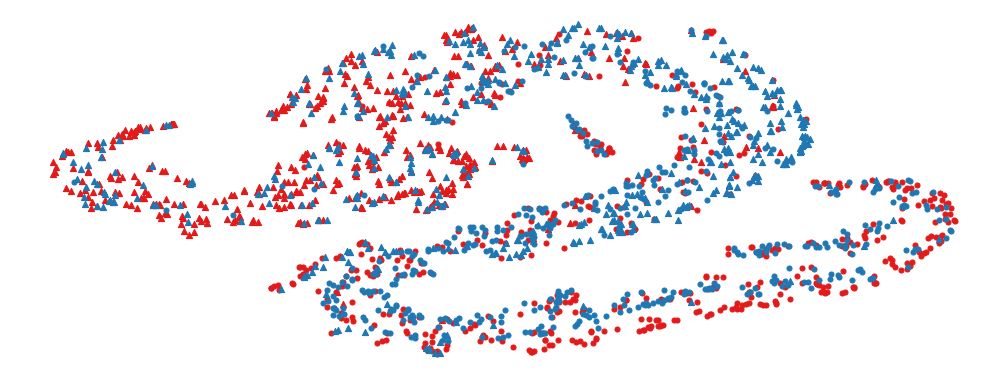

In [17]:
feature_extractor = torch.nn.Sequential(backbone, baseline_adaptor)
features, targets = save_features(train_s_loader, val_loader, feature_extractor)
features = transform_features(features)
plot_features(features, targets)

## Invariant Consistency Learning

### Clustering T

As the data size is small, for simplicity, we consider an out-of-box clustering algorithm from scikit-learn. Recall from main paper that we can use any clustering algorithm as long as the number of output clusters can be specified.

In [93]:
from sklearn.cluster import AgglomerativeClustering
backbone = resnet50(pretrained=True).cuda()
backbone.fc = nn.Identity()
backbone.eval()

# loaders
train_s_loader = torch.utils.data.DataLoader(mnist_s, batch_size=128, shuffle=True, drop_last=False, num_workers=24)
val_loader = torch.utils.data.DataLoader(mnist_t, batch_size=128, shuffle=False, drop_last=False, num_workers=24)
t_features, t_targets = save_features(None, val_loader, backbone)
ac = AgglomerativeClustering(n_clusters=2)
cluster_labels = ac.fit_predict(t_features)

### Use cluster labels in T
For each training sample in T, we assign it the corresponding cluster label. This can be easily implemented by updating the targets list in the dataset and recreating the dataloader.

In [106]:
from common.utils.data import ForeverDataIterator
mnist_t_unlab.targets = torch.from_numpy(cluster_labels)
train_t_loader = torch.utils.data.DataLoader(mnist_t_unlab, batch_size=128, shuffle=True, drop_last=False, num_workers=24)

train_source_iter = ForeverDataIterator(train_s_loader)
train_target_iter = ForeverDataIterator(train_t_loader)

### ICON Training

Again, for direct comparison, we adopt a very simple implementation by just adding the BCE loss in T, such that the classifier needs to separate the two clusters identified earlier. Note that the cross-entropy loss in S already separates the labels in S, hence we omit the BCE loss in S. And in this example, there is no dominating domain, so we omit the invariant constraint as well. Please refer to our code on Office-Home, VisDA-2017 and WILDS 2.0 for a full implementation.

In [116]:
import torch.nn.functional as F
from cluster import BCE, PairEnum
bce = BCE()

adaptor = nn.Sequential(nn.Linear(2048, 64), nn.ReLU(), nn.Linear(64, 16)).cuda()
fc = nn.Linear(16, 2).cuda()

# optimizer
optimizer = torch.optim.SGD(list(adaptor.parameters())+list(fc.parameters()), 0.01,momentum=0.9,weight_decay=1e-4)

for epoch in range(5):
    loss_avg = 0.0
    acc_avg = 0.0
    if epoch > 2:
        # update cluster labels using the learned feature
        t_features, t_targets = save_features(None, val_loader, nn.Sequential(backbone, adaptor))
        ac = AgglomerativeClustering(n_clusters=2)
        cluster_labels_updated = ac.fit_predict(t_features)
        acc1 = (t_targets == cluster_labels_updated).sum() / float(len(t_targets))
        acc2 = (t_targets != cluster_labels_updated).sum() / float(len(t_targets))
        # print(max(acc1, acc2))      # Clustering acc
        mnist_t_unlab.targets = torch.from_numpy(cluster_labels_updated)
        train_t_loader = torch.utils.data.DataLoader(mnist_t_unlab, batch_size=128, shuffle=True, drop_last=False, num_workers=24)
        train_target_iter = ForeverDataIterator(train_t_loader)
        
    backbone.eval()
    adaptor.train()
    for i in range(50):
        images_s, labels_s = next(train_source_iter)
        images_t, labels_t = next(train_target_iter)
        optimizer.zero_grad()
        images_s, images_t = images_s.cuda(), images_t.cuda()
        labels_s = labels_s.cuda()
        labels_t = labels_t.cuda()
        with torch.no_grad():
            b_features = backbone(torch.cat((images_s, images_t), dim=0))
        features = adaptor(b_features)
        outputs = fc(features)
        outputs_nograd = fc(features.detach())
        ce_loss = nn.CrossEntropyLoss()(outputs[:len(outputs)//2], labels_s)
        
        # NOTE: labels_t are the cluster labels (see the code block above)
        labels_t_view = labels_t.contiguous().view(-1, 1)
        sim_matrix_ulb = torch.eq(labels_t_view, labels_t_view.T).float().cuda()
        sim_matrix_ulb = (sim_matrix_ulb - 0.5) * 2.0  # same label=1.0, diff label=-1.0
        
        cluster_logits = outputs_nograd if epoch <= 2 else outputs
        p_t = F.softmax(cluster_logits[len(outputs)//2:], dim=1)
        pairs1, _ = PairEnum(p_t)
        _, pairs2 = PairEnum(p_t)
        bce_t_loss = bce(pairs1, pairs2, sim_matrix_ulb.flatten())
        
        loss = ce_loss + bce_t_loss
        
        loss.backward()
        acc1 = accuracy(outputs[:len(outputs)//2], labels_s, topk=(1,))[0]
        optimizer.step()   
        loss_avg += loss.item() / 50
        acc_avg += acc1.item() / 50
    print("Avg loss: %.4f" % loss_avg)
    print("Average acc:%.2f" % acc_avg)

    adaptor.eval()
    acc_avg = 0.0
    for images, targets in val_loader:
        images = images.cuda()
        targets = targets.cuda()
        with torch.no_grad():
            b_features = backbone(images)
            features = adaptor(b_features)
            outputs = fc(features)
        acc1 = accuracy(outputs, targets, topk=(1,))[0]
        acc_avg += acc1.item() / len(val_loader)
    print("Average val acc:%.2f" % acc_avg)
    print("")

Avg loss: 1.2758
Average acc:68.11
Average val acc:57.91

Avg loss: 0.9415
Average acc:91.68
Average val acc:67.50

Avg loss: 0.8759
Average acc:93.38
Average val acc:72.65

Avg loss: 0.8077
Average acc:91.97
Average val acc:86.49

Avg loss: 0.8071
Average acc:92.31
Average val acc:85.30



By comparing the average val acc in the target domain of ICON (max 86.49) with the baseline (max 75.03), we can already see a huge difference. We will visualize the features learned by ICON in the next step.

### Visualizing ICON Features

We can clearly see that ICON model separates 0s and 1s simultaneously in S and T, i.e., most blue dots (0s in T) are near red dots (0s in S) and most blue triangles (1s in T) are near red triangles (1s in S). This shows that ICON disentangles the digit shape from the spurious digit color and achieves much robust generalization to T.

In [109]:
backbone.eval()
adaptor.eval()
val_loader = torch.utils.data.DataLoader(mnist_t, batch_size=128, shuffle=False, drop_last=False, num_workers=24)
feature_extractor = torch.nn.Sequential(backbone, adaptor)
features, targets = save_features(train_s_loader, val_loader, feature_extractor)
features = transform_features(features)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 12665 samples in 0.016s...
[t-SNE] Computed neighbors for 12665 samples in 0.312s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12665
[t-SNE] Computed conditional probabilities for sample 2000 / 12665
[t-SNE] Computed conditional probabilities for sample 3000 / 12665
[t-SNE] Computed conditional probabilities for sample 4000 / 12665
[t-SNE] Computed conditional probabilities for sample 5000 / 12665
[t-SNE] Computed conditional probabilities for sample 6000 / 12665
[t-SNE] Computed conditional probabilities for sample 7000 / 12665
[t-SNE] Computed conditional probabilities for sample 8000 / 12665
[t-SNE] Computed conditional probabilities for sample 9000 / 12665
[t-SNE] Computed conditional probabilities for sample 10000 / 12665
[t-SNE] Computed conditional probabilities for sample 11000 / 12665
[t-SNE] Computed conditional probabilities for sample 12000 / 12665
[t-SNE] Computed conditional probabilities for sam

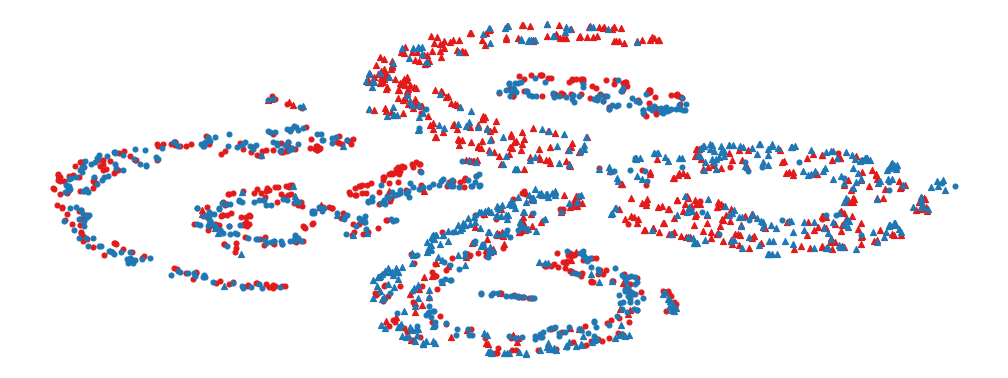

In [110]:
plot_features(features, targets)